In [3]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns
import seaborn as sns
from scipy.stats import norm, chi2,gumbel_r
import scipy.optimize as sco
import datetime

In [4]:
%run "Stock Data.ipynb".ipynb

In [5]:
stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]

In [6]:
tickers=stocks['Ticker'].to_list()

In [7]:
data=get_close(tickers,"2022-01-01")
data=data.dropna()
n=len(data.columns)

In [8]:
returns=np.log(1+data.pct_change())

# General Functions

In [9]:
def halton_sequences(number,base=2):
    
    #Generate Halton sequences
    
    inv_base=1/base
    
    i=number
    halton=0
    
    while i>0:
        
        digit = i%base
        halton=halton + digit*inv_base
        i=(i-digit)/base
        inv_base=inv_base/base
        
    return halton

def generate_halton(iterations,dimensions=1,base=2):
    
    #Generate a Halton Sequences at basis k , then shuffles it
    
    rng = np.random.default_rng()
    matrix=[]
    haltons=[]
    
    for i in range(iterations):
        halton=halton_sequences(i,base=base)
        haltons.append(halton)
    
    for dim in range(dimensions):
        
        matrix.append(haltons)
    
    matrix = rng.permuted(matrix, axis=1)
    return matrix

def near_psd(x, epsilon=0):
    
    #Calculate the nearest positive semi definite matrix

    if min(np.linalg.eigvals(x))> epsilon:
        return x

    n = x.shape[0]
    var_list = np.array(np.sqrt(np.diag(x)))
    y = np.array([[x[i, j]/(var_list[i]*var_list[j]) for i in range(n)] for j in range(n)])

    eigval, eigvec = np.linalg.eig(y)
    val = np.matrix(np.maximum(eigval, epsilon))
    vec = np.matrix(eigvec)
    T = 1/(np.multiply(vec, vec) * val.T)
    T = np.matrix(np.sqrt(np.diag(np.array(T).reshape((n)) )))
    B = T * vec * np.diag(np.array(np.sqrt(val)).reshape((n)))
    near_corr = B*B.T    

    near_cov = np.array([[near_corr[i, j]*(var_list[i]*var_list[j]) for i in range(n)] for j in range(n)])
    return near_cov

In [10]:

def performance(perf,weights):
    
    #Calculate the performance of a portfolio on a daily basis
    
    return np.dot(perf,weights)


In [11]:
def rolling_var(returns,weights,window=30,Q=1):

    #This function will return the rolling VaR on a x-days window following historical,parametric and multivariate model

    value_at_risk=pd.DataFrame()

    mean=returns.rolling(window).mean().dropna()
    cov=returns.rolling(window).cov().dropna()
    corr=returns.rolling(window).corr().dropna()
    std=returns.rolling(window).std().dropna()

    index=sorted(tuple(set(cov.index.get_level_values(0))))


    var={}

    for date in index:
            
            multivariate_var=performance(np.random.multivariate_normal(mean.loc[date],cov.loc[date],10000),weights) 
            var[date]=np.percentile(multivariate_var,Q)


    var=pd.DataFrame(var.values(),index=var.keys())

    portfolio=Portfolio(returns).portfolio(weights)

    value_at_risk['Historical']=portfolio.rolling(window=window).apply(lambda x:np.percentile(x,Q))
    value_at_risk['Parametric']=portfolio.rolling(window=window).std()*norm(loc =0 , scale = 1).ppf(Q/100)
    value_at_risk['Multivariate']=var
    value_at_risk['Portfolio']=portfolio

    return value_at_risk.dropna()

def kupiec_test(rolling_var,Q=5):

    number_obs=rolling_var.shape[0]
    confidence=Q/100

    ret=(1+rolling_var['Portfolio']).cumprod()
    return_mean=(ret.iloc[-1])**(1/number_obs)-1

    stats={}

    stats['Proportion of failure']=[]
    stats['Kupiec Stat']=[]
    stats['P-value']=[]
    stats['Model']=[]

    for col in rolling_var.columns:

        if col=='Portfolio':

            continue

        else:

            number_violation=np.sum(np.where(rolling_var[col]>rolling_var['Portfolio'],1,0))
            number_non_violation=number_obs-number_violation
            proportion_violation=number_violation/number_obs
            proportion_non_violation=1-proportion_violation

            kupiec=2*np.log((proportion_non_violation/(1-confidence))**(number_non_violation)*
                                (proportion_violation/confidence)**number_violation)

            p_value=1-chi2.cdf(kupiec,1)

        stats['Kupiec Stat'].append(kupiec)
        stats['P-value'].append(p_value)
        stats['Proportion of failure'].append(proportion_violation)
        stats['Model'].append(col)

    stats=pd.DataFrame(stats.values(),index=stats.keys(),columns=stats['Model'])
    stats=stats.drop(stats.index[3])

    return stats


## Portfolio Construction

In [12]:
class Portfolio:
    
    #This class allows the user to calculate various metrics of a portfolio
    #and also allows to optmize the portfolio with various constraints
    
    def __init__(self,data):
        
        self.data=data

    def portfolio(self,weights):
            
        portfolio=pd.DataFrame()
        portfolio['Portfolio']=np.sum(weights*returns,axis=1)
        
        return portfolio
    
    def evolution(self,weights):
        
        portfolio=self.portfolio(weights)
        evolution=(1+portfolio).cumprod()*100
        
        return evolution
    
    def performance(self,weights):
        performance=np.sum(self.data*weights).mean()*252
        return performance
    
    def variance(self,weights):
        variance=np.sqrt(np.dot(weights.T,np.dot(self.data.cov(),weights)))*np.sqrt(252)
        return variance
    
    def sharpe_ratio(weights):
            return self.performance(weights)/self.variance(weights)

    def optimize(self,objective='minimum_variance',constraints=False):
        
            
        def sum_equal_one(weight):
            return np.sum(weight) - 1   
        
        def sharpe_ratio(weights):
            return - self.performance(weights)/self.variance(weights)
        
        def variance(weights):
            variance=np.sqrt(np.dot(weights.T,np.dot(self.data.cov(),weights)))*np.sqrt(252)
            return variance
        
        n_assets = len(self.data.columns)
        weight = np.array([1 / n_assets] * n_assets)
        bounds = tuple((0, 1) for _ in range(n_assets))
        
        if not constraints:
            
            constraints = [{'type': 'eq', 'fun': sum_equal_one}]
        
        else:
            
            constraints=[{'type': 'eq', 'fun': sum_equal_one}]+constraints
        
        if objective=='minimum_variance':

            optimum_weights = sco.minimize(variance, weight, method='SLSQP', bounds=bounds, constraints=constraints)
        
        elif objective=='sharpe_ratio':
            
            optimum_weights = sco.minimize(sharpe_ratio, weight, method='SLSQP', bounds=bounds, constraints=constraints)
            
        else:
            
            print("Objective function undefined")
            
            
        return optimum_weights.x
    
    def black_Litterman(self,P,Q,weights,risk_aversion,tau=0.025):
        
        implied_returns=risk_aversion*self.data.cov().dot(weights).squeeze()
        omega=np.diag(np.diag(P.dot(tau*self.data.cov()).dot(P.T)))
        sigma_scaled=self.data.cov()*tau
        BL_returns= implied_returns + sigma_scaled.dot(P.T).dot(np.linalg.inv(P.dot(sigma_scaled).dot(P.T))+omega).dot(Q-P.dot(implied_returns))
        inv_cov=np.linalg.inv(self.data.cov())
        BL_weights=inv_cov.dot(BL_returns)
        BL_weights=BL_weights/BL_weights.sum()
        
        return BL_weights,BL_returns

## Risk Analysis

In [13]:
class RiskAnalysis(Portfolio):
    
    
    #This class is used to assess various risk of a portfolio such as Market Risk, VaR
    # and to know which asset could possibly contribute to it
    
    def __init__(self,returns):
        
        self.returns=returns
        super().__init__(data=returns)
        

    def historical_var(self,weights,last_days=False,Q=5):
        
        #Return Historical VaR on the Past x days at Q confidence interval

        performance=super().portfolio(weights)
        
        if last_days:
            performance=performance[-last_days:]
            
        var=np.percentile(performance,Q)
        cvar=performance[performance<var].mean().values[0]
        
        return var,cvar
    
    
    def parametric_var(self,weights,Q=0.95):
        
        #Return parametric VaR, where assets follows a Normal Distribution
        
        intervals=np.arange(Q, 1, 0.0005, dtype=float)
        
        variance=super().variance(weights)
        VaR=variance/np.sqrt(252)*norm(loc =0 , scale = 1).ppf(1-Q)
        CVaR=variance/np.sqrt(252)*norm(loc =0 , scale = 1).ppf(1-intervals).mean()
        
        return VaR,CVaR
        
        
    def multivariate_distribution(self,
                    stress_factor=1.0,
                    iterations=10000):
        
        #Return Multivariate Distribution of a portfolio taking into account potential correlation
        
        num_asset=len(self.returns.columns)
        
        if type(stress_factor)==float:
            
            stress_vec=np.linspace(stress_factor,stress_factor,num_asset)
            
        else:       
            stress_vec=stress_factor
            
        stress_matrix=np.diag(stress_vec)
        stress_matrix=pd.DataFrame(stress_matrix,columns=self.returns.columns,index=self.returns.columns)
        
        stressed_cov=self.returns.cov().dot(stress_matrix)
        mean=self.returns.mean()
        
        multivariate=np.random.multivariate_normal(mean,stressed_cov,iterations)
        
        return multivariate
    
    def gaussian_copula(self,iterations=10000):
        
        randoms=np.random.normal(size=(10000,self.returns.shape[1])).T
        near_psd_corr=near_psd(self.returns.corr())
        cholesky=np.linalg.cholesky(self.returns.corr())

        simulation=np.matmul(cholesky,randoms).T
        simulation=pd.DataFrame(simulation)
        simulation.columns=self.returns.columns

        copula_sample=simulation*self.returns.std()+self.returns.mean()
        
        return copula_sample
    
    def t_copula(self,iterations=10000):
        
        df=self.returns.shape[1]*self.returns.shape[1]//2+self.returns.shape[1]
        ChiSquared = np.random.chisquare(df=df, size=iterations)

        randoms=np.random.normal(size=(10000,self.returns.shape[1])).T
        near_psd_corr=near_psd(self.returns.corr())
        cholesky=np.linalg.cholesky(self.returns.corr())

        simulation=np.matmul(cholesky,randoms)/np.sqrt(ChiSquared/df)
        simulation=pd.DataFrame(simulation.T)
        simulation.columns=self.returns.columns

        copula_sample=simulation*self.returns.std()+self.returns.mean()
        
        return copula_sample
    
    def monte_carlo(self,spot,horizon=20/250,iterations=100000,stress_factor=1.0):
        
        
        
        num_asset=len(self.returns.columns)
        #haltons=generate_halton(iterations,num_asset,base=2)
        randoms=np.random.normal(size=(10000,num_asset)).T
        
        # Create a stress matrix to stress the covariance matrix
        
        if type(stress_factor)==float:
            
            stress_vec=np.linspace(stress_factor,stress_factor,num_asset)
            
        else: 
            
            stress_vec=stress_factor
        
        
        #Stress the volatilities of the assets
        
        vol=self.returns.std()*np.sqrt(250)*stress_vec
        
        #Create a diagonal matrix of the stress factors
        
        stress_matrix=np.diag(stress_vec)
        stress_matrix=pd.DataFrame(stress_matrix,columns=self.returns.columns,index=self.returns.columns)
        
        #Find nearest PSD matrix and apply cholesky decomposition to create correaltion effect in Monte Carlo
        
        stressed_cov=self.returns.cov().dot(stress_matrix)
        stressed_std=np.sqrt(np.diag(stressed_cov))
        corr_matrix=stressed_cov/np.outer(stressed_std,stressed_std)
        sdp_corr_matrix=near_psd(corr_matrix)
        
        cholesky=np.linalg.cholesky(corr_matrix)
            
        drift=np.exp(-0.5*horizon*vol**2)
        factors=spot*drift
        factors_vec=factors.to_numpy().reshape(num_asset,-1)
                
        simulation=np.matmul(cholesky,randoms).T
        simulation=pd.DataFrame(simulation)
        simulation.columns=self.returns.columns
 
        
        monte_carlo=factors_vec.T*np.exp(simulation.dot(np.diag(vol))*np.sqrt(horizon))
        monte_carlo=pd.DataFrame(monte_carlo)
        monte_carlo.columns=self.returns.columns
        perf_monte_carlo=np.log(monte_carlo/spot)
        
        return monte_carlo,perf_monte_carlo
      

    
    def pca(self,num_components=2):
        
        #Returns the eigen vectors of the covariance matrix
        
        cov_matrix=self.returns.cov()
                
        eig_val, eig_vec=np.linalg.eig(cov_matrix)
        sorted_eig_val=eig_val.argsort()[::-1]
        eig_val=eig_val[sorted_eig_val]
        eig_vec=eig_vec[:,sorted_eig_val]
        eig_val=eig_val[:num_components]
        eig_vec=eig_vec[:,0:num_components]
        
        PC={}
        
        for i in range(eig_vec.shape[1]):
            
            PC["PC" +str(i+1)]=eig_vec[:,i]/eig_vec[:,i].sum()
        
        
        portfolio_components=pd.DataFrame(PC.values(),index=PC.keys(),columns=data.columns).T
        
        return eig_val,eig_vec,portfolio_components
    

    def var_contrib(self,weights):
        
        weights_matrix=np.diag(weights)
        variance_contrib=np.dot(weights_matrix,np.dot(self.returns.cov()*252,weights_matrix.T))
        
        asset_contrib=variance_contrib.sum(axis=0)    
        diag=np.diag(variance_contrib.diagonal())
        variance_decomposition=np.column_stack([asset_contrib,variance_contrib.diagonal(),(variance_contrib-diag).sum(axis=0)])
        contrib=pd.DataFrame(variance_decomposition,index=self.returns.columns,columns=['Variance Contribution','Idiosyncratic Risk','Correlation'])
        
        weighted_covar=pd.DataFrame(variance_contrib,columns=self.returns.columns,index=self.returns.columns)
        
        return contrib,weighted_covar
    
    def var_contrib_pct(self,weights):
        
        var_contrib=self.var_contrib(weights)[0]
        var_contrib=var_contrib/var_contrib['Variance Contribution'].sum()        
        return var_contrib
    

In [37]:
test=RiskAnalysis(returns)

In [38]:
num_asset=len(data.columns)
weights=np.random.rand(num_asset)
weights=weights/weights.sum()

In [39]:
weights=test.optimize(objective="minimum_variance",constraints=[{'type': 'ineq', 'fun': lambda weights: 0.1 - weights}])
weights=np.round(weights,2)

In [40]:
weights

array([0.  , 0.  , 0.1 , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02,
       0.  , 0.  , 0.  , 0.  , 0.1 , 0.1 , 0.  , 0.1 , 0.  , 0.06, 0.  ,
       0.02, 0.  , 0.  , 0.1 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.02, 0.02, 0.  , 0.08, 0.  , 0.  , 0.  , 0.1 , 0.09, 0.  ,
       0.  , 0.  , 0.08, 0.  , 0.  , 0.  ])

In [41]:
var,cvar=test.historical_var(weights)
var,cvar

(-0.01198497660988435, -0.017868901905570885)

In [42]:
var,cvar=test.parametric_var(weights)
var,cvar

(-0.012825018540503299, -0.016438127847683476)

In [43]:
perf=performance(test.multivariate_distribution(),weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0124265273352113, -0.01598070878061722)

In [44]:
cop=test.gaussian_copula()
perf=performance(cop,weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.012693009066898398, -0.015932909432820132)

In [45]:
t_copula=test.t_copula()
perf=performance(t_copula,weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.012643377178812924, -0.01591985217455458)

In [46]:
spot=data.iloc[-1]
monte_carlo=test.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1],weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.012773602791669746, -0.01610636536719221)

In [47]:
var_data=rolling_var(returns,weights,window=30,Q=1).dropna()
var_data

,Historical,Parametric,Multivariate,Portfolio
2022-02-16,-0.024406,-0.021280,-0.021963,-0.006828
2022-02-17,-0.024406,-0.021227,-0.022408,-0.003141
2022-02-18,-0.024406,-0.020781,-0.021542,-0.002602
2022-02-21,-0.024406,-0.021889,-0.023289,-0.017013
2022-02-22,-0.024406,-0.021414,-0.022964,0.000076
...,...,...,...,...
2024-04-24,-0.010450,-0.012596,-0.011494,-0.007118
2024-04-25,-0.010450,-0.012594,-0.011998,-0.001477
2024-04-26,-0.010450,-0.012813,-0.011899,0.006069
2024-04-29,-0.010450,-0.012770,-0.012112,-0.000109


<AxesSubplot:>

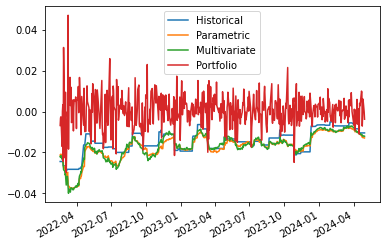

In [48]:
var_data.plot()

In [49]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.042593,0.012963,0.007407
Kupiec Stat,0.655346,21.870813,31.739775
P-value,0.418208,0.000003,0.0


In [50]:
eigval,eigvec,portfolio_components=test.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.68083229, 0.13757873, 0.07810222, 0.05314766, 0.0503391 ])

In [51]:
#portfolio_components

<AxesSubplot:>

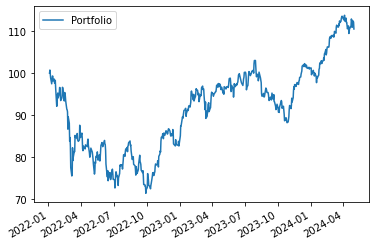

In [52]:
test.evolution(portfolio_components["PC1"]).plot()

<AxesSubplot:>

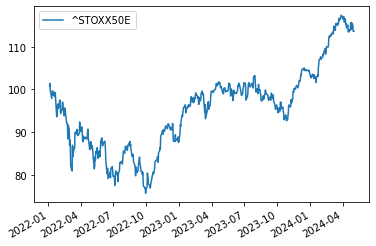

In [53]:
((1+get_close(['^STOXX50E'],"2022-01-01").pct_change()).cumprod()*100).plot()

In [54]:
var_contrib_pct=test.var_contrib_pct(weights)
var_contrib_pct=var_contrib_pct.loc[(var_contrib_pct!=0).any(axis=1)]
var_contrib_pct=var_contrib_pct.sort_values('Variance Contribution', ascending=False)
var_contrib_pct

,Variance Contribution,Idiosyncratic Risk,Correlation
SAN.PA,0.104784,0.043557,0.061227
IBE.MC,0.099485,0.028125,0.071360
SAP.DE,0.099186,0.030900,0.068286
DTE.DE,0.097774,0.026292,0.071482
BN.PA,0.092747,0.022756,0.069991
TTE.PA,0.088548,0.032026,0.056522
RI.PA,0.087186,0.023346,0.063840
DB1.DE,0.085679,0.026703,0.058976
AD.AS,0.078609,0.028601,0.050008
ENI.MI,0.066836,0.016710,0.050126


In [209]:
dico_ptf=dict(zip(returns.columns,weights))
te=((1+returns).cumprod()*weights)#.dropna()

In [210]:
#plo=te.loc[:, (te != 0).any(axis=0)]

In [211]:
last_nav=te.iloc[-1].sum()

In [212]:
last_row=te.iloc[-1]

In [213]:
last_weight=last_row/last_nav
last_weight

ADS.DE       0.000000
ADYEN.AS     0.000000
AD.AS        0.084040
AI.PA        0.010916
AIR.PA       0.000000
ALV.DE       0.000000
ABI.BR       0.000000
ASML.AS      0.000000
CS.PA        0.000000
BAS.DE       0.000000
BAYN.DE      0.009371
BBVA.MC      0.000000
SAN.MC       0.000000
BMW.DE       0.000000
BNP.PA       0.000000
BN.PA        0.092062
DB1.DE       0.106029
DHL.DE       0.000000
DTE.DE       0.118684
ENEL.MI      0.000000
ENI.MI       0.066510
EL.PA        0.000000
RACE.MI      0.026803
FLTR.L       0.000000
RMS.PA       0.000000
IBE.MC       0.101154
ITX.MC       0.000000
IFX.DE       0.000000
INGA.AS      0.000000
ISP.MI       0.000000
KER.PA       0.000000
OR.PA        0.000000
MC.PA        0.000000
MBG.DE       0.000000
MUV2.DE      0.027862
NOKIA.HE     0.010275
NDA-FI.HE    0.000000
RI.PA        0.044755
PRX.AS       0.000000
SAF.PA       0.000000
SGO.PA       0.000000
SAN.PA       0.090883
SAP.DE       0.101417
SU.PA        0.000000
SIE.DE       0.000000
STLAM.MI  

In [214]:
perf=last_row/weights

In [220]:
perf_contrib=(perf-1)*weights

In [233]:
perf_report=pd.DataFrame(perf_contrib.dropna())
perf_report.columns=['Performance Contribution']

In [234]:
perf_report.sort_values(by='Performance Contribution',ascending=False)

,Performance Contribution
TTE.PA,0.046662
DTE.DE,0.037614
SAP.DE,0.027592
DB1.DE,0.022940
IBE.MC,0.017288
ENI.MI,0.017118
MUV2.DE,0.012306
RACE.MI,0.011078
BN.PA,0.006746
SAN.PA,0.005379


In [222]:
(1+returns[perf_report.index]).cumprod()

,AD.AS,AI.PA,BAYN.DE,BN.PA,DB1.DE,DTE.DE,ENI.MI,RACE.MI,IBE.MC,MUV2.DE,NOKIA.HE,RI.PA,SAN.PA,SAP.DE,TTE.PA
2022-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-05,1.010611,1.016125,1.005447,0.998055,1.003066,0.996364,1.011512,1.007627,0.993237,1.012966,1.012730,1.003240,1.002268,1.003531,1.011941
2022-01-07,1.001213,0.993007,1.005550,0.993808,0.993122,0.978540,1.014204,0.956144,1.005569,1.011286,0.978042,0.941578,1.006008,0.974659,1.023882
2022-01-10,1.002034,0.990719,1.030988,1.004872,1.001615,0.938413,1.005764,0.938568,0.980715,1.015379,0.982719,0.945733,1.008843,0.970310,1.030034
2022-01-11,1.020247,0.994900,1.056626,1.006461,1.016178,0.958147,1.015706,0.950804,0.981205,1.017055,0.980191,0.934095,1.021817,0.977994,1.048814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-24,0.951231,1.281480,0.533777,1.087687,1.226405,1.394272,1.293843,1.579569,1.175135,1.628333,0.595527,0.662826,0.993919,1.352910,1.567993
2024-04-25,0.955334,1.264012,0.532291,1.079282,1.231485,1.387853,1.295370,1.550392,1.167979,1.658869,0.591320,0.646402,1.037381,1.310961,1.571452
2024-04-26,0.959437,1.274706,0.544334,1.060926,1.239603,1.399333,1.295880,1.583359,1.183167,1.620404,0.598869,0.650954,1.032956,1.339909,1.603902
2024-04-29,0.963199,1.269325,0.548096,1.067458,1.236205,1.395485,1.297068,1.576118,1.187744,1.623536,0.601482,0.649354,1.039839,1.319892,1.598583
